In [27]:
#"Imports et chemin de base
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = "datafinal"  

In [29]:
# 1) Charger les fichiers JSON (train / others / dev)
# ============================================================
with open(os.path.join(DATA_DIR, "train_spider.json"), "r", encoding="utf8") as f:
    train = json.load(f)

with open(os.path.join(DATA_DIR, "train_others.json"), "r", encoding="utf8") as f:
    train_others = json.load(f)

with open(os.path.join(DATA_DIR, "dev.json"), "r", encoding="utf8") as f:
    dev = json.load(f)

# Ajouter un champ "split" pour savoir d’où vient chaque exemple
for row in train:
    row["split"] = "train_spider"
for row in train_others:
    row["split"] = "train_others"
for row in dev:
    row["split"] = "dev"

# DataFrame global
df = pd.DataFrame(train + train_others + dev)
df.head()


,db_id,query,query_toks,query_toks_no_value,question,question_toks,sql,split
0,department_management,SELECT count(*) FROM head WHERE age > 56,"[SELECT, count, (, *, ), FROM, head, WHERE, ag...","[select, count, (, *, ), from, head, where, ag...",How many heads of the departments are older th...,"[How, many, heads, of, the, departments, are, ...","{'except': None, 'from': {'conds': [], 'table_...",train_spider
1,department_management,"SELECT name , born_state , age FROM head ORD...","[SELECT, name, ,, born_state, ,, age, FROM, he...","[select, name, ,, born_state, ,, age, from, he...","List the name, born state and age of the heads...","[List, the, name, ,, born, state, and, age, of...","{'except': None, 'from': {'conds': [], 'table_...",train_spider
2,department_management,"SELECT creation , name , budget_in_billions ...","[SELECT, creation, ,, name, ,, budget_in_billi...","[select, creation, ,, name, ,, budget_in_billi...","List the creation year, name and budget of eac...","[List, the, creation, year, ,, name, and, budg...","{'except': None, 'from': {'conds': [], 'table_...",train_spider
3,department_management,"SELECT max(budget_in_billions) , min(budget_i...","[SELECT, max, (, budget_in_billions, ), ,, min...","[select, max, (, budget_in_billions, ), ,, min...",What are the maximum and minimum budget of the...,"[What, are, the, maximum, and, minimum, budget...","{'except': None, 'from': {'conds': [], 'table_...",train_spider
4,department_management,SELECT avg(num_employees) FROM department WHER...,"[SELECT, avg, (, num_employees, ), FROM, depar...","[select, avg, (, num_employees, ), from, depar...",What is the average number of employees of the...,"[What, is, the, average, number, of, employees...","{'except': None, 'from': {'conds': [], 'table_...",train_spider


1) train_spider.json

👉 Le fichier principal d’entraînement

Ce fichier contient :

la majorité des exemples

des questions variées

des requêtes SQL correctes

des bases de données associées

C’est le cœur du dataset, celui utilisé pour entraîner les modèles dans les articles de recherche.

➡️ Nombre d’exemples : ~7 000
➡️ Objectif : entraîner le modèle

🟨 2) train_others.json

👉 Données supplémentaires d’entraînement

Ce fichier contient :

des exemples additionnels

souvent issus d’autres jeux (WikiSQL, Spider-like, etc.)

utilisés pour renforcer la diversité des questions

Il sert à augmenter les données d’entraînement, mais ce n’est pas le fichier principal.

➡️ Nombre d’exemples : ~2 000
➡️ Objectif : améliorer la généralisation du modèle

🟥 3) dev.json

👉 Jeu de validation (test)

Ce fichier est utilisé uniquement pour évaluer les modèles.

Caractéristiques :

contient des bases non présentes dans train

simule un vrai scénario de généralisation

permet de mesurer les performances du modèle avant test final

➡️ Nombre d’exemples : ~1 034
➡️ Objectif : évaluer le modèle sans l’entraîner dessus

In [3]:
# ============================================================
# 2) Infos globales sur la dataset
# ============================================================
print("Nombre total d'exemples :", len(df))
print("Répartition par split :")
print(df["split"].value_counts(), "\n")

print("Nombre de bases différentes :", df["db_id"].nunique())
print("Quelques db_id :", df["db_id"].unique()[:15])


Nombre total d'exemples : 9693
Répartition par split :
split
train_spider    7000
train_others    1659
dev             1034
Name: count, dtype: int64 

Nombre de bases différentes : 166
Quelques db_id : ['department_management' 'farm' 'student_assessment' 'bike_1' 'book_2'
 'musical' 'twitter_1' 'product_catalog' 'flight_1' 'allergy_1' 'store_1'
 'journal_committee' 'customers_card_transactions' 'race_track'
 'coffee_shop']


In [5]:
# ============================================================
# 3) Quelques exemples aléatoires (Question / SQL / DB)
# ============================================================
sample = df.sample(5, random_state=0)[["db_id", "question", "query"]]
for i, row in sample.iterrows():
    print("="*80)
    print("Base     :", row["db_id"])
    print("Question :", row["question"])
    print("SQL      :", row["query"])


Base     : scholar
Question : What papers have been written by Peter Mertens and Dina Barbian ?
SQL      : SELECT DISTINCT t3.paperid FROM writes AS t3 JOIN author AS t2 ON t3.authorid  =  t2.authorid JOIN writes AS t4 ON t4.paperid  =  t3.paperid JOIN author AS t1 ON t4.authorid  =  t1.authorid WHERE t2.authorname  =  "Peter Mertens" AND t1.authorname  =  "Dina Barbian";
Base     : flight_2
Question : Which airlines have departures from CVO but not from APG airports?
SQL      : SELECT T1.Airline FROM AIRLINES AS T1 JOIN FLIGHTS AS T2 ON T1.uid  =  T2.Airline WHERE T2.SourceAirport  =  "CVO" EXCEPT SELECT T1.Airline FROM AIRLINES AS T1 JOIN FLIGHTS AS T2 ON T1.uid  =  T2.Airline WHERE T2.SourceAirport  =  "APG"
Base     : geo
Question : what is the population of the largest state that borders texas
SQL      : SELECT population FROM state WHERE area  =  ( SELECT MAX ( area ) FROM state WHERE state_name IN ( SELECT border FROM border_info WHERE state_name  =  "texas" ) ) AND state_name I

In [7]:
# ============================================================
# 4) Statistiques sur les longueurs (questions & SQL)
# ============================================================
df["question_length"] = df["question"].apply(lambda x: len(x.split()))
df["sql_length"] = df["query"].apply(lambda x: len(x.split()))

print("Longueur moyenne des questions :", df["question_length"].mean())
print("Min / Max questions :", df["question_length"].min(), "/", df["question_length"].max())

print("Longueur moyenne des requêtes SQL :", df["sql_length"].mean())
print("Min / Max SQL :", df["sql_length"].min(), "/", df["sql_length"].max())


Longueur moyenne des questions : 12.084700299184979
Min / Max questions : 1 / 39
Longueur moyenne des requêtes SQL : 17.994944805529762
Min / Max SQL : 4 / 87


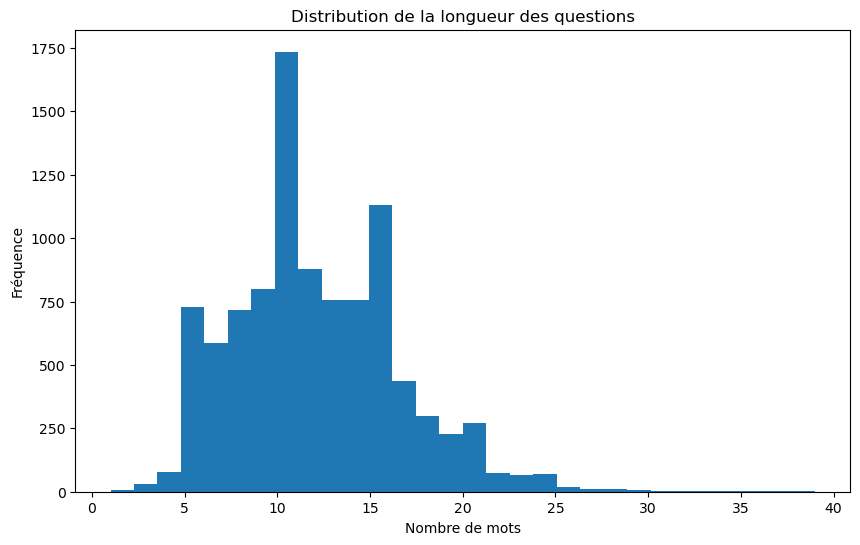

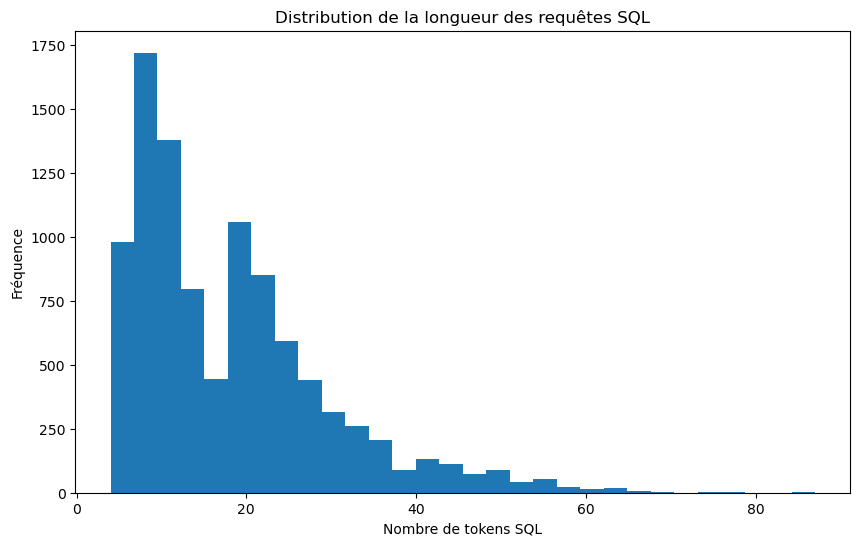

In [9]:
# (Optionnel) Visualisation longueur des questions
plt.figure(figsize=(10,6))
df["question_length"].plot(kind="hist", bins=30)
plt.title("Distribution de la longueur des questions")
plt.xlabel("Nombre de mots")
plt.ylabel("Fréquence")
plt.show()

# (Optionnel) Visualisation longueur des requêtes SQL
plt.figure(figsize=(10,6))
df["sql_length"].plot(kind="hist", bins=30)
plt.title("Distribution de la longueur des requêtes SQL")
plt.xlabel("Nombre de tokens SQL")
plt.ylabel("Fréquence")
plt.show()


###COURBE1 
La majorité des questions contiennent entre 8 et 15 mots.
Le pic principal se situe autour de 10–12 mots, ce qui correspond à des questions relativement courtes mais informatives.
Les questions très courtes (< 5 mots) sont rares.
Les questions très longues (> 20 mots) représentent une faible proportion du dataset, mais existent.
Quelques questions atteignent 30 à 40 mots, ce qui indique des requêtes SQL plus complexes (nesting, filtrage multiple, conditions composées…).

###COURBE2
La plupart des requêtes SQL contiennent entre 5 et 25 tokens, ce qui indique une prédominance de requêtes simples à modérément complexes.
La distribution montre une longue traîne jusqu’à 80 tokens, correspondant aux requêtes les plus difficiles avec plusieurs jointures ou sous-requêtes.
Cette variété de longueurs reflète la diversité des niveaux de difficulté dans Spider et renforce son rôle de benchmark exigeant pour le Text-to-SQL.

Nombre de questions par base (top 10) :
db_id
scholar        569
geo            564
academic       181
college_2      170
college_1      164
restaurants    125
hr_1           124
world_1        120
store_1        112
yelp           111
Name: count, dtype: int64


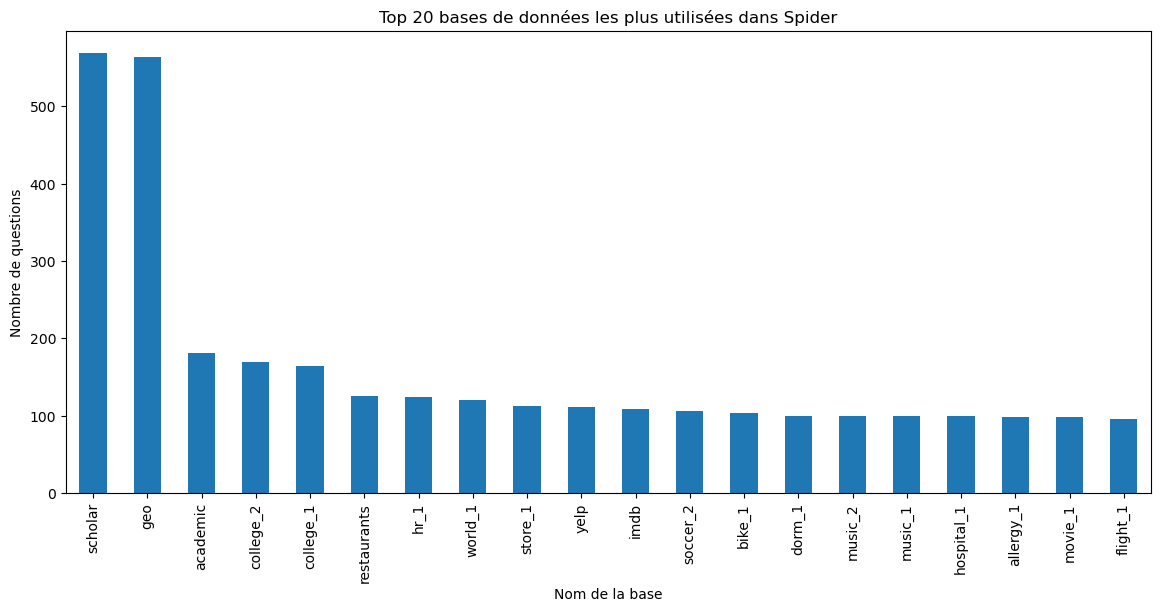

In [11]:
# ============================================================
# 5) Répartition des questions par base (db_id)
# ============================================================
db_counts = df["db_id"].value_counts()
print("Nombre de questions par base (top 10) :")
print(db_counts.head(10))

plt.figure(figsize=(14,6))
db_counts.head(20).plot(kind="bar")
plt.title("Top 20 bases de données les plus utilisées dans Spider")
plt.xlabel("Nom de la base")
plt.ylabel("Nombre de questions")
plt.show()


Les bases scholar et geo dominent largement le dataset avec plus de 550 questions chacune, ce qui indique qu’elles contribuent fortement à l’apprentissage du modèle.
La majorité des autres bases parmi le Top 20 contiennent entre 100 et 200 questions, montrant une distribution inégale mais variée.

Pourcentage de requêtes contenant :
 - JOIN    : 43.70 %
 - GROUP BY: 23.01 %
 - HAVING  : 5.47 %


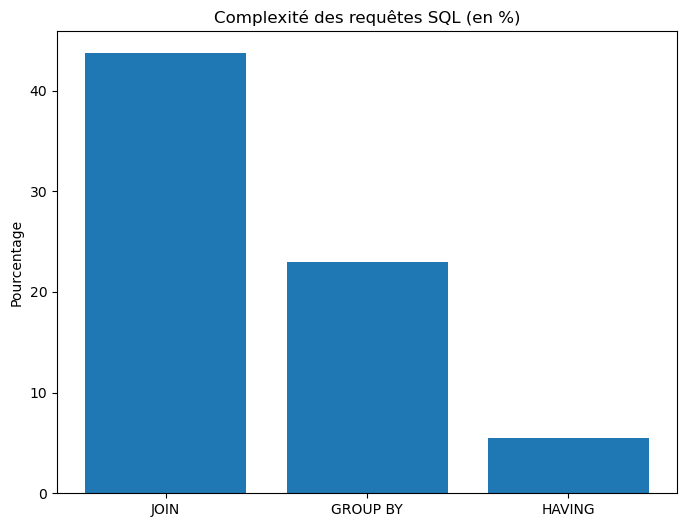

In [13]:
# ============================================================
# 6) Complexité SQL : présence de JOIN / GROUP BY / HAVING
# ============================================================
df["has_join"] = df["query"].str.contains("JOIN", case=False)
df["has_group"] = df["query"].str.contains("GROUP BY", case=False)
df["has_having"] = df["query"].str.contains("HAVING", case=False)

stats_complex = {
    "JOIN": df["has_join"].mean() * 100,
    "GROUP BY": df["has_group"].mean() * 100,
    "HAVING": df["has_having"].mean() * 100,
}

print("Pourcentage de requêtes contenant :")
for k, v in stats_complex.items():
    print(f" - {k:8s}: {v:.2f} %")

plt.figure(figsize=(8,6))
plt.bar(stats_complex.keys(), stats_complex.values())
plt.title("Complexité des requêtes SQL (en %)")
plt.ylabel("Pourcentage")
plt.show()


Près de 45 % des requêtes contiennent au moins un JOIN, montrant que Spider repose fortement sur des schémas relationnels et des jointures complexes.
Environ 23 % des requêtes utilisent GROUP BY, ce qui traduit la présence fréquente d’agrégations et de statistiques.
Les requêtes avec HAVING restent minoritaires (~5 %), indiquant que les cas très avancés d’agrégation filtrée sont rares mais présents.

In [15]:
# ============================================================
# 7) Charger tables.json (schémas des bases)
# ============================================================
with open(os.path.join(DATA_DIR, "tables.json"), "r", encoding="utf8") as f:
    tables_meta = json.load(f)

print("Nombre de schémas dans tables.json :", len(tables_meta))
print("Clés disponibles dans un schéma :", tables_meta[0].keys())


Nombre de schémas dans tables.json : 166
Clés disponibles dans un schéma : dict_keys(['column_names', 'column_names_original', 'column_types', 'db_id', 'foreign_keys', 'primary_keys', 'table_names', 'table_names_original'])


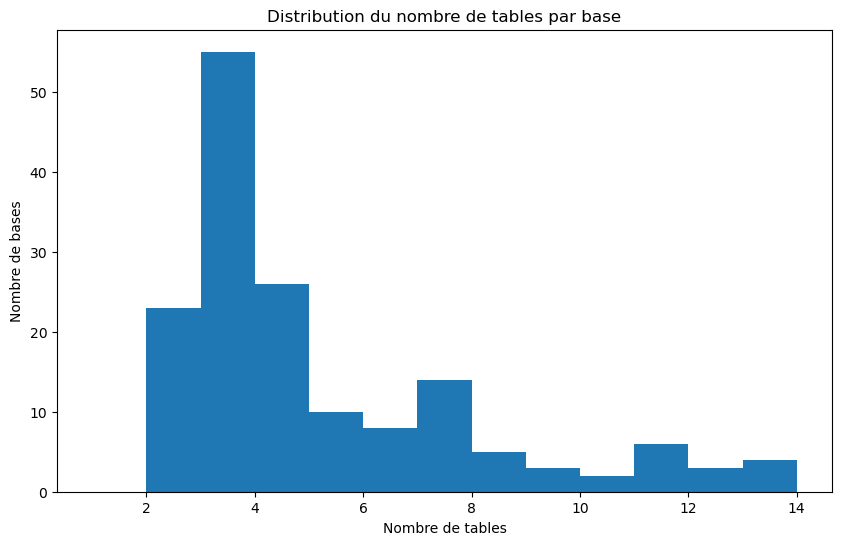

In [19]:
# 8) Distribution du nombre de tables par base
plt.figure(figsize=(10,6))
schema_df["n_tables"].plot(kind="hist", bins=range(1, 15))
plt.title("Distribution du nombre de tables par base")
plt.xlabel("Nombre de tables")
plt.ylabel("Nombre de bases")
plt.show()


In [21]:
# ============================================================
# 9) Fusion stats schéma + stats questions
# ============================================================
schema_with_counts = schema_df.merge(db_counts.rename("n_questions"),
                                     left_on="db_id", right_index=True, how="left")
schema_with_counts.sort_values("n_questions", ascending=False).head(10)


,db_id,n_tables,n_columns,n_foreign_keys,n_questions
120,scholar,10,26,8,569
139,geo,7,30,6,564
8,academic,15,43,18,181
1,college_2,11,47,20,170
107,college_1,7,44,9,164
73,restaurants,3,13,2,125
110,hr_1,7,36,7,124
95,world_1,4,27,2,120
128,store_1,12,67,11,112
125,yelp,7,39,7,111


In [23]:
# ============================================================
# 10) Fonctions utilitaires pour EXPLORER une base (schéma + questions)
# ============================================================
# Indexer les schémas par db_id pour accès rapide
schemas = {db["db_id"]: db for db in tables_meta}

def show_schema(db_id):
    """Afficher le schéma (tables, colonnes, FKs) d'une base Spider."""
    if db_id not in schemas:
        print("db_id inconnu :", db_id)
        return
    
    db = schemas[db_id]
    print("\n=== SCHÉMA DE LA BASE :", db_id, "===\n")

    print("Tables :")
    for i, tname in enumerate(db["table_names"]):
        print(f"  [{i}] {tname}")

    print("\nColonnes :")
    for (tid, col_name) in db["column_names"]:
        tname = db["table_names"][tid] if tid >= 0 else "(global)"
        print(f"  {tname:20s} → {col_name}")

    print("\nForeign Keys :")
    for (c1, c2) in db["foreign_keys"]:
        t1, col1 = db["column_names"][c1]
        t2, col2 = db["column_names"][c2]
        print(f"  {db['table_names'][t1]}.{col1}  →  {db['table_names'][t2]}.{col2}")


In [25]:
def inspect_database(db_id, n=3):
    """Afficher schéma + quelques questions/SQL pour une base donnée."""
    show_schema(db_id)
    print("\n=== Exemples de questions pour cette base ===")
    sub = df[df["db_id"] == db_id].head(n)
    for _, row in sub.iterrows():
        print("-"*80)
        print("Question :", row["question"])
        print("SQL      :", row["query"])

# Exemple d'utilisation :
inspect_database("scholar", n=3)
# tu peux tester aussi :
# inspect_database("geo", n=3)
# inspect_database("college_1", n=3)



=== SCHÉMA DE LA BASE : scholar ===

Tables :
  [0] author
  [1] cite
  [2] dataset
  [3] journal
  [4] key phrase
  [5] paper
  [6] paper dataset
  [7] paper key phrase
  [8] venue
  [9] writes

Colonnes :
  (global)             → *
  author               → author id
  author               → author name
  cite                 → citing paper id
  cite                 → cited paper id
  dataset              → dataset id
  dataset              → dataset name
  journal              → journal id
  journal              → journal name
  key phrase           → key phrase id
  key phrase           → key phrase name
  paper                → paper id
  paper                → title
  paper                → venue id
  paper                → year
  paper                → number of citing
  paper                → number cited by
  paper                → journal id
  paper dataset        → paper id
  paper dataset        → dataset id
  paper key phrase     → paper id
  paper key phrase     → key phr